# Vehicle Detection Project
---

In [74]:
'''
import pickle

file_Name = "tmp_data"

#a = [X_scaler, cls]
#fileObject = open(file_Name,'wb') 
#pickle.dump(a,fileObject)   

fileObject = open(file_Name,'rb')  
b = pickle.load(fileObject)  
X_scaler = b[0]
cls = b[1]

fileObject.close()

print(cls)
print(X_scaler)
'''

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=999,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)
StandardScaler(copy=True, with_mean=True, with_std=True)


The goals / steps of this project are the following:
- Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
- Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
- Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
- Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
- Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
- Estimate a bounding box for vehicles detected.

## Reading all the images

In [75]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob


In [76]:
cars = glob.glob('./car_noncar_images/vehicles/*/*.png')
notcars = glob.glob('./car_noncar_images/non-vehicles/*/*.png')

# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    img_eg = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = img_eg.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = img_eg.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


Visualize some data

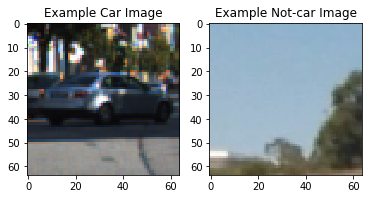

In [77]:
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

# save 
fig.savefig('./output_images/car_notcar_eg.png')

## Extract features of Histogram of Oriented Gradients (HOG) from images

In [78]:
from skimage.feature import hog

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=True, 
                     feature_vec=True):
                         
    """
    Function accepts params and returns HOG features (optionally flattened) and an optional matrix for 
    visualization. Features will always be the first return (flattened if feature_vector= True).
    A visualization matrix will be the second return if visualize = True.
    """
    
    return_list = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys', transform_sqrt=False, 
                                  visualise= vis, feature_vector= feature_vec)
    
    # name returns explicitly    
    if vis:
        hog_features = return_list[0]
        hog_image = return_list[1]
        return hog_features, hog_image
    else:
        hog_features = return_list
        return hog_features

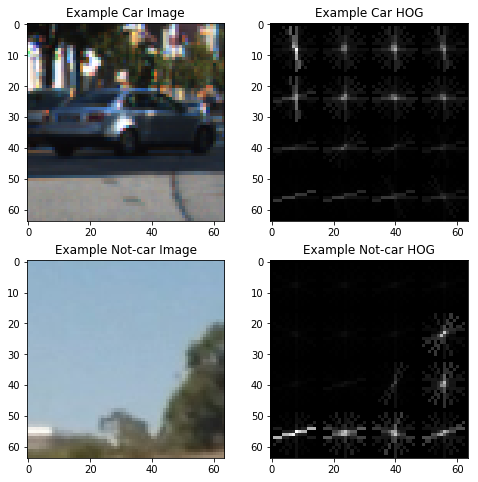

In [83]:
car_gray = cv2.cvtColor(car_image, cv2.COLOR_RGB2GRAY)
notcar_gray = cv2.cvtColor(notcar_image, cv2.COLOR_RGB2GRAY)

_, car_dst = get_hog_features(car_gray, orient= 12, 
                        pix_per_cell= 16, cell_per_block=2, 
                        vis=True, feature_vec=True)
_, notcar_dst = get_hog_features(notcar_gray, orient= 9, 
                        pix_per_cell= 16, cell_per_block=2, 
                        vis=True, feature_vec=True)

# Plot the examples
fig = plt.figure(figsize=(8, 8))
plt.subplot(221)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(222)
plt.imshow(car_dst,cmap='gray')
plt.title('Example Car HOG')
plt.subplot(223)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')
plt.subplot(224)
plt.imshow(notcar_dst,cmap='gray')
plt.title('Example Not-car HOG')

# save 
fig.savefig('./output_images/eg_hog.png')

In [84]:
# Define a function to extract hog features from a list of images
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

In [85]:
cspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

In [86]:
import time
t=time.time()
car_features = extract_features(cars, cspace=cspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=cspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

91.87 Seconds to extract HOG features...


## Shuffle, split and normalize features

In [87]:
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split

In [88]:

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)


# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)


print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 12 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1296


## Train the classifier

In [89]:
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

Train the Linear SVC classifier.

In [90]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

6.2 Seconds to train SVC...
Test Accuracy of SVC =  0.9721
My SVC predicts:  [ 0.  0.  0.  0.  1.  0.  0.  0.  1.  0.]
For these 10 labels:  [ 0.  0.  0.  0.  1.  0.  0.  0.  1.  0.]
0.02698 Seconds to predict 10 labels with SVC


Train a Multi-Layer Perceptron classifier:

In [91]:
# use a MLPclassifier
mlp = MLPClassifier(random_state=999)
# Check the training time for the MLP
t=time.time()
mlp.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train MLP...')
# Check the score of the MLP
print('Test Accuracy of MLP = ', round(mlp.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My MLP predicts: ', mlp.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with MLP')

19.06 Seconds to train MLP...
Test Accuracy of MLP =  0.9901
My MLP predicts:  [ 0.  0.  0.  0.  1.  0.  0.  0.  1.  0.]
For these 10 labels:  [ 0.  0.  0.  0.  1.  0.  0.  0.  1.  0.]
0.02099 Seconds to predict 10 labels with MLP


In [92]:
# choose the MLP as classifier
cls = mlp

## Hog Sub-sampling Window Search

When using the sliding window approach as introduced in the course, it is relatively inefficient as the HOG feature of each sliding window has to be extracted for each. Instead, in this project, we tried a more efficient method which HOG feature of the image needs to be extracted only once, for each of a small set of predetermined window sizes (defined by a scale argument), and then can be sub-sampled to get all of its overlaying windows. The fuction for this purpose is defined as such: 

In [93]:
# Define a single function that can extract features using hog sub-sampling and make predictions
# def find_cars(img, ystart, ystop, scale, cls, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
def find_cars(img, cspace, ystart, ystop, scale, cls, X_scaler, orient, pix_per_cell, cell_per_block,shwAllWindows=False):    
    rectangles = []
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(img_tosearch)   
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, vis=False,feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block,vis=False, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block,vis=False, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            '''
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = cls.predict(test_features)
            '''
            
            test_features = X_scaler.transform(hog_features.reshape(1,-1))   
            # test_features = hog_features.reshape(1,-1)
            test_prediction = cls.predict(test_features)
            
            if test_prediction == 1 or shwAllWindows==True:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles
    

## Draw Rectangles function

Plus, we also need to define a function to draw rectangles onto images. 

In [94]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # make a copy of the image
    draw_img = np.copy(img)   
    
    # draw each bounding box on your image copy using cv2.rectangle()
    # return the image copy with boxes drawn
    for i in range(len(bboxes)):
        if color=='random':
            draw_color = (np.random.randint(256),np.random.randint(256),np.random.randint(256))
        else:
            draw_color = color
        cv2.rectangle(draw_img, bboxes[i][0], bboxes[i][1],draw_color,thick)   
    
    return draw_img # Change this line to return image copy with boxes

## Adjust searching area and scale of sliding windows

When calling the `find_cars()` function, the searching area and scale of the sliding windows need to be defined. In this project, the purpose is vehicle detection. The vehicles will most likely appear in the bottom half of the shot images, and their relative size in the image varies with their relative distance from the camera. Therefore, the parameters `ystart`, `ystop`, and `scale` need to be tuned to make the size of the sliding window capable to contain the whole vehicle in that position. 
To better visualize all the sliding windows in the test images, the color for the sliding windows are set to random colors, inspired by Jemery Shannon's idea here (https://github.com/jeremy-shannon/CarND-Vehicle-Detection/blob/master/vehicle_detection_project.ipynb). 
The tuned parameters and corresponding visualization results are shown below:

In [95]:
test_img = mpimg.imread('./test_images/test1.jpg')

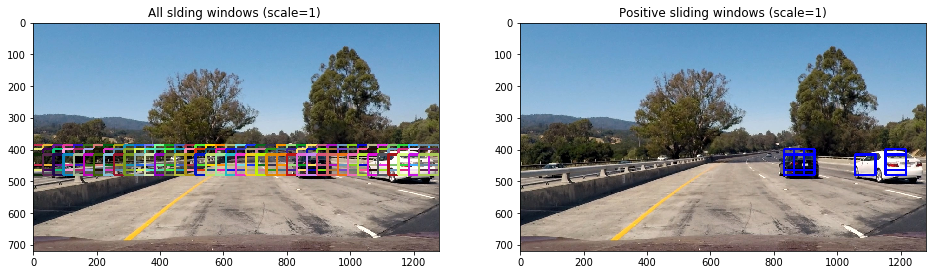

In [103]:
all_rects = []
pos_rects = []

scale = 1

ystart = 386
ystop = 466
all_rects += find_cars(test_img, cspace,ystart, ystop, scale, cls, X_scaler, orient, pix_per_cell, cell_per_block, True)
ystart = 400
ystop = 480
all_rects += find_cars(test_img, cspace,ystart, ystop, scale, cls, X_scaler, orient, pix_per_cell, cell_per_block, True)
ystart = 416
ystop = 480
all_rects += find_cars(test_img, cspace,ystart, ystop, scale, cls, X_scaler, orient, pix_per_cell, cell_per_block, True)
color = 'random'
out_img = draw_boxes(test_img, all_rects, color)

fig = plt.figure(figsize=(16,5))
plt.subplot(121)
plt.imshow(out_img)
plt.title('All slding windows (scale=1) ')

ystart = 386
ystop = 466
pos_rects += find_cars(test_img, cspace,ystart, ystop, scale, cls, X_scaler, orient, pix_per_cell, cell_per_block, False)
ystart = 400
ystop = 480
pos_rects += find_cars(test_img, cspace,ystart, ystop, scale, cls, X_scaler, orient, pix_per_cell, cell_per_block, False)
ystart = 416
ystop = 480
pos_rects += find_cars(test_img, cspace,ystart, ystop, scale, cls, X_scaler, orient, pix_per_cell, cell_per_block, False)
color = (0,0,255)
out_img = draw_boxes(test_img, pos_rects, color)

plt.subplot(122)
plt.imshow(out_img)
plt.title('Positive sliding windows (scale=1)')

# save 
fig.savefig('./output_images/adjust_scale1.png')

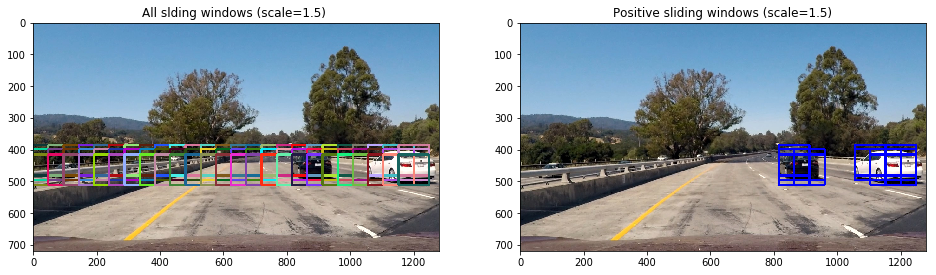

In [104]:
all_rects = []
pos_rects = []

scale = 1.5

ystart = 386
ystop = 486
all_rects += find_cars(test_img, cspace,ystart, ystop, scale, cls, X_scaler, orient, pix_per_cell, cell_per_block, True)
pos_rects += find_cars(test_img, cspace,ystart, ystop, scale, cls, X_scaler, orient, pix_per_cell, cell_per_block, False)
ystart = 400
ystop = 500
all_rects += find_cars(test_img, cspace,ystart, ystop, scale, cls, X_scaler, orient, pix_per_cell, cell_per_block, True)
pos_rects += find_cars(test_img, cspace,ystart, ystop, scale, cls, X_scaler, orient, pix_per_cell, cell_per_block, False)
ystart = 416
ystop = 516
all_rects += find_cars(test_img, cspace,ystart, ystop, scale, cls, X_scaler, orient, pix_per_cell, cell_per_block, True)
pos_rects += find_cars(test_img, cspace,ystart, ystop, scale, cls, X_scaler, orient, pix_per_cell, cell_per_block, False)

color = 'random'
out_img = draw_boxes(test_img, all_rects, color)

fig = plt.figure(figsize=(16,5))
plt.subplot(121)
plt.imshow(out_img)
plt.title('All slding windows (scale=1.5) ')

color = (0,0,255)
out_img = draw_boxes(test_img, pos_rects, color)

plt.subplot(122)
plt.imshow(out_img)
plt.title('Positive sliding windows (scale=1.5)')

# save 
fig.savefig('./output_images/adjust_scale1p5.png')

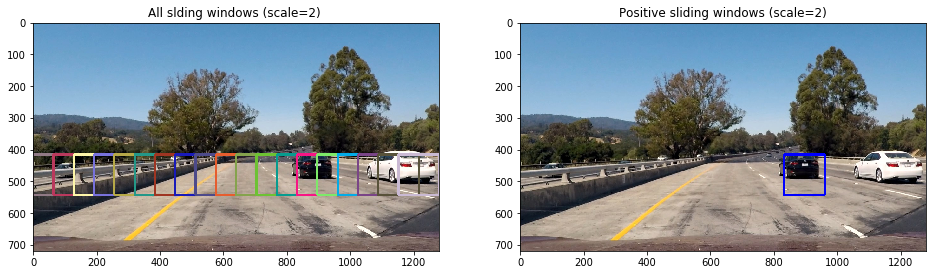

In [105]:
all_rects = []
pos_rects = []

scale = 2

ystart = 416
ystop = 550
all_rects += find_cars(test_img, cspace,ystart, ystop, scale, cls, X_scaler, orient, pix_per_cell, cell_per_block, True)
pos_rects += find_cars(test_img, cspace,ystart, ystop, scale, cls, X_scaler, orient, pix_per_cell, cell_per_block, False)

color = 'random'
out_img = draw_boxes(test_img, all_rects, color)

fig = plt.figure(figsize=(16,5))
plt.subplot(121)
plt.imshow(out_img)
plt.title('All slding windows (scale=2) ')

color = (0,0,255)
out_img = draw_boxes(test_img, pos_rects, color)

plt.subplot(122)
plt.imshow(out_img)
plt.title('Positive sliding windows (scale=2)')

# save 
fig.savefig('./output_images/adjust_scale2.png')

## Combine different search area and scales of sliding widows

Combine all the seraching areas with corresponding scale of sliding windows, we define a function as below:

In [106]:
# define function including searching areas with corresponding different scales of sliding windows
def find_cars_diffScales(test_img, cspace,cls,X_scaler,orient,pix_per_cell,cell_per_block):
    
    rectangles = []
    
    scale = 1  
    
    ystart = 386
    ystop = 466   
    rectangles += find_cars(test_img, cspace,ystart, ystop, scale, cls, X_scaler, orient, pix_per_cell, cell_per_block, False) 
    ystart = 400
    ystop = 480    
    rectangles += find_cars(test_img, cspace,ystart, ystop, scale, cls, X_scaler, orient, pix_per_cell, cell_per_block, False) 
    ystart = 416
    ystop = 480
    rectangles += find_cars(test_img, cspace,ystart, ystop, scale, cls, X_scaler, orient, pix_per_cell, cell_per_block, False) 
    
    scale = 1.5
    ystart = 386
    ystop = 486
    rectangles +=  find_cars(test_img, cspace,ystart, ystop, scale, cls, X_scaler, orient, pix_per_cell, cell_per_block, False) 
    ystart = 400
    ystop = 500
    rectangles +=  find_cars(test_img, cspace,ystart, ystop, scale, cls, X_scaler, orient, pix_per_cell, cell_per_block, False) 
    ystart = 416
    ystop = 516
    rectangles +=  find_cars(test_img, cspace,ystart, ystop, scale, cls, X_scaler, orient, pix_per_cell, cell_per_block, False) 
    
    scale = 2
    #ystart = 400
    #ystop = 530    
    #rectangles += find_cars(test_img, cspace,ystart, ystop, scale, cls, X_scaler, orient, pix_per_cell, cell_per_block, False) 
    ystart = 416
    ystop = 550
    rectangles += find_cars(test_img, cspace,ystart, ystop, scale, cls, X_scaler, orient, pix_per_cell, cell_per_block, False) 
    '''
    scale = 3
    ystart = 400
    ystop = 600
    rectangles += find_cars(test_img, cspace,ystart, ystop, scale, cls, X_scaler, orient, pix_per_cell, cell_per_block, False) 
    ystart = 464
    ystop = 660
    rectangles += find_cars(test_img, cspace,ystart, ystop, scale, cls, X_scaler, orient, pix_per_cell, cell_per_block, False) 
    ''' 
    return rectangles

Visualize the dected boxes in the test image:

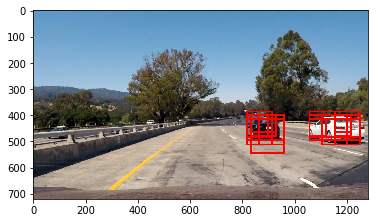

In [108]:
rectangles = find_cars_diffScales(test_img, cspace,cls,X_scaler,orient,pix_per_cell,cell_per_block)

color=  (255,0,0)
out_img = draw_boxes(test_img, rectangles, color)

fig = plt.figure()
plt.imshow(out_img)

# save 
fig.savefig('./output_images/windows_beforeHM.png')

## Apply Heatmap to remove wrong detection

It can be seen that in the above test image, some sliding windows without car objects are mis-classified. We have to introduce heatmap to remove these mis-classified windows. 

Define `add_heat` function to count on positive detection of pixels in the image. 

In [109]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    


The heatmap after calling `add_heat` function is visualized as below:

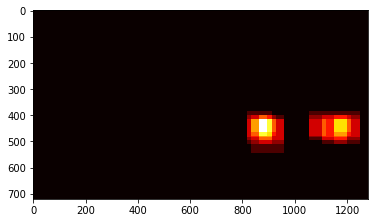

In [110]:
heat = np.zeros_like(test_img[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,rectangles)

fig = plt.figure()
plt.imshow(heat,cmap='hot')

# save 
fig.savefig('./output_images/add_heat.png')


Reset regions in the heatmap to zero when the positive detection count is below (<=) threshold. 

In [111]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

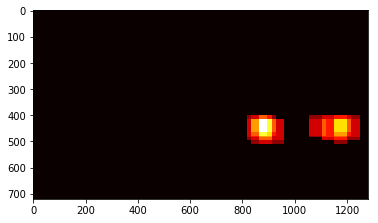

In [112]:
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

fig = plt.figure()
plt.imshow(heatmap,cmap='hot')

# save 
fig.savefig('./output_images/threshold_heat.png')

Draw the image with labeled regions. 

2 cars found


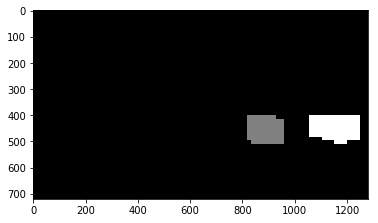

In [113]:
from scipy.ndimage.measurements import label
    
# Find final boxes from heatmap using label function
labels = label(heatmap)

print(labels[1], 'cars found')

fig = plt.figure()
plt.imshow(labels[0], cmap='gray')
# save 
fig.savefig('./output_images/label_gray.png')

Define function to draw labeled boxes in the test image after applying `scipy.ndimage.measurements.label`.

In [114]:
def draw_labeled_bboxes(img, labels):
    out_img = np.copy(img)
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(out_img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return out_img

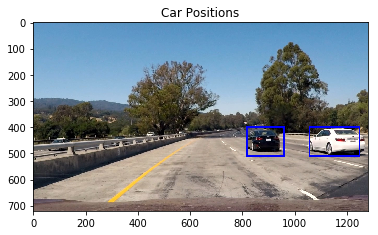

In [115]:
draw_img = draw_labeled_bboxes(test_img, labels)

fig = plt.figure()
plt.imshow(draw_img)
plt.title('Car Positions')
# save 
fig.savefig('./output_images/label_img.png')

## Pipeline for processing image

Put is all together, we define the following pipleline to detect vehicles for single frame or image.

In [116]:
def process_img(img):
  
    rectangles = find_cars_diffScales(img, cspace,cls,X_scaler,orient,pix_per_cell,cell_per_block)
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,rectangles)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    draw_img = draw_labeled_bboxes(img, labels)
    
    return draw_img
    

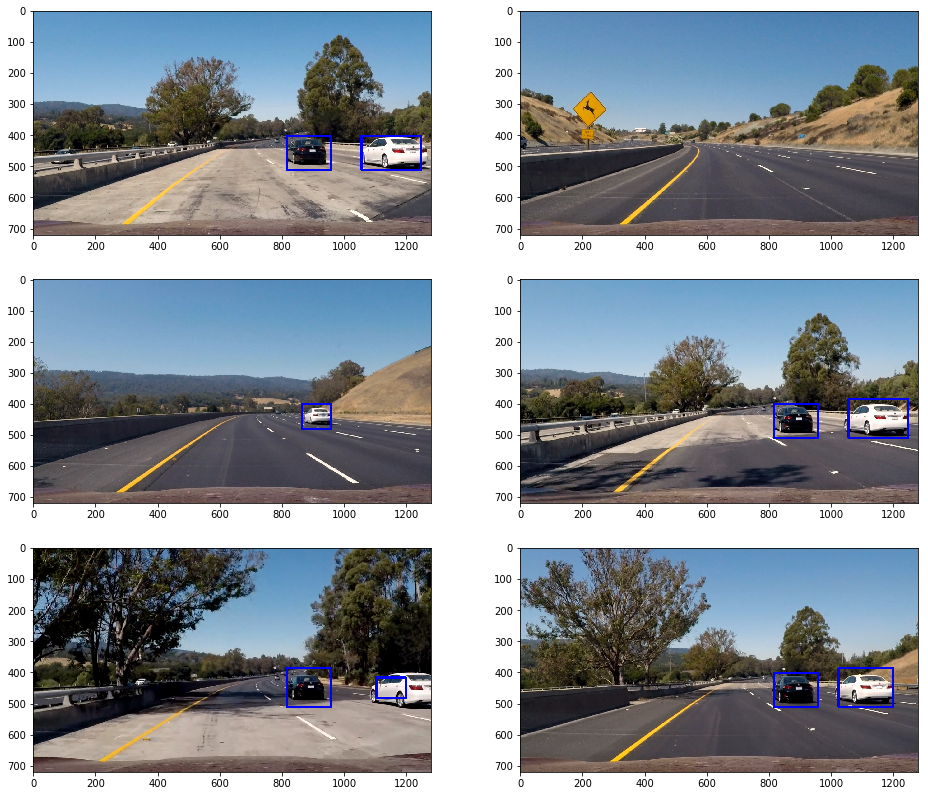

In [120]:
test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
axs = axs.ravel()

i = 0
for file in test_images:
    axs[i].imshow(process_img(mpimg.imread(file)))
    i += 1

# save 
fig.savefig('./output_images/out_testImgs.png')    

## Pipeline for processing videos

If using the same pipeline for videos without taking advantage of neighboring frames, we get the following videos. 

In [121]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [28]:
video_output1 = 'test_video_bad.mp4'
video_input1 = VideoFileClip('test_video.mp4')#.subclip(1,2)
processed_video = video_input1.fl_image(process_img)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video test_video_bad.mp4
[MoviePy] Writing video test_video_bad.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:19<00:00,  1.99it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_bad.mp4 

Wall time: 20.7 s


Although for this small test video the pipeline runs fine, it can be seen for a single image in the previous section, false positives sometime still persist even after applying heatmap and threshold. We have to further improve the pipeline by utilizing the information from neighboring frames. 
It is thus natural to use informaiton from neighbouring frames from a video to better decide whether the detected positives are true or false again by applying heatmap and threshold but this time for several frames in a row for a video. 
First let's define a class to store positive rectangles. 

In [122]:
# Define a class to store data from video
class boxlist_frames():
    def __init__(self):
        # history of rectangles of n frames
        self.boxlist = [] 
        self.n = 0
        self.max_n = 40
        
    def add_boxs(self, boxs):
        self.boxlist.append(boxs)
        self.n += 1
        if self.n > self.max_n:
            # throw out oldest rectangle set(s)
            self.boxlist = self.boxlist[len(self.boxlist)-self.max_n:]
            self.n = self.max_n

The pipeline to process video frames are as shown below:

In [123]:
def process_frame(img):
    
    rectangles = find_cars_diffScales(img, cspace,cls,X_scaler,orient,pix_per_cell,cell_per_block)
    
    boxlist_for_video.add_boxs(rectangles)
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    for boxs in boxlist_for_video.boxlist:
        '''
        # generate heat map for indiviudal frame first
        heat_i = np.zeros_like(img[:,:,0]).astype(np.float)
        heat_i = add_heat(heat_i,boxs)
        # apply threshold 1 to indiviudal frame
        heat_i = apply_threshold(heat_i,1)
        # heat map for these frames together
        heat += heat_i
        '''
        heat = add_heat(heat,boxs)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, np.int(np.ceil(1+boxlist_for_video.n*1)))

    # Find final boxes from heatmap using label function
    labels = label(heat)
    
    draw_img = draw_labeled_bboxes(img, labels)
    
    return draw_img

Apply the pipleline onto the test video. 

In [40]:
boxlist_for_video = boxlist_frames()

video_output2 = 'test_video_output.mp4'
video_input1 = VideoFileClip('test_video.mp4')#.subclip(1,2)
processed_video = video_input1.fl_image(process_frame)
%time processed_video.write_videofile(video_output2, audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:17<00:00,  2.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

Wall time: 19.9 s


Apply the pipleline onto the project video. 

In [ ]:
boxlist_for_video = boxlist_frames()

video_output3 = 'project_video_output.mp4'
video_input2 = VideoFileClip('project_video.mp4')#.subclip(1,10)
processed_video = video_input2.fl_image(process_frame)
%time processed_video.write_videofile(video_output3, audio=False)